In [ ]:
#@title install latex for plots description
! sudo apt -qq install texlive-latex-extra
! sudo apt -qq install dvipng
! sudo apt-get -qq install texlive-full

In [ ]:
#@title setup for plots
import matplotlib.pyplot as plt 

alpha_field = .3

# RGB colors.
colors20 = [(31, 119, 180), (174, 199, 232), (255, 127, 14), (255, 187, 120),
             (44, 160, 44), (152, 223, 138), (214, 39, 40), (255, 152, 150),
             (148, 103, 189), (197, 176, 213), (140, 86, 75), (196, 156, 148),
             (227, 119, 194), (247, 182, 210), (127, 127, 127), (199, 199, 199),
             (188, 189, 34), (219, 219, 141), (23, 190, 207), (158, 218, 229)]
# Scale the RGB values to the [0, 1] range.
for i in range(len(colors20)):
    red, green, blue = colors20[i]
    colors20[i] = (red / 255., green / 255., blue / 255.)

markers = ['o','v','^','<','>','8','s','d','h','H','+','x','X','D','d','|','_']
markersize = 4 
m_edge_width = .5

c_gda = colors20[1] #0
c_ogda = colors20[9] #1
c_eg = colors20[0]
c_la = colors20[7]
c_acvi = colors20[4]
m_gda = markers[0]
m_ogda = markers[1]
m_eg = markers[4]
m_la = markers[7]
m_acvi = markers[6]


rcParams = plt.rcParams

rcParams['text.latex.preamble'] = [r"\usepackage{lmodern}"]
# plt.rcParams['text.latex.preamble'] = [r"\usepackage{upgreek}"]
rcParams['figure.figsize'] = 5, 4.24
rcParams['text.usetex'] = True
rcParams['figure.dpi'] = 190
rcParams['font.family'] = 'lmodern'
rcParams['font.size'] = '12.5'
rcParams['text.latex.unicode'] = True

# -----------------------------------------------------------------------------
from matplotlib.ticker import NullFormatter

# Constrained Bilinear Game

Last iteration of GDA: [0.         0.89988659]
Last iteration of EG: [0.         0.83432591]
Last iteration of OGDA: [0.         0.83372403]
Last iteration of LA5-GDA: [3.56754342e-15 5.20545846e-01]
Last iteration of ACVI: [5.45849268e-10 9.54402216e-03]
Solution at: [0, 0]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:73: RuntimeWarning: invalid value encountered in log


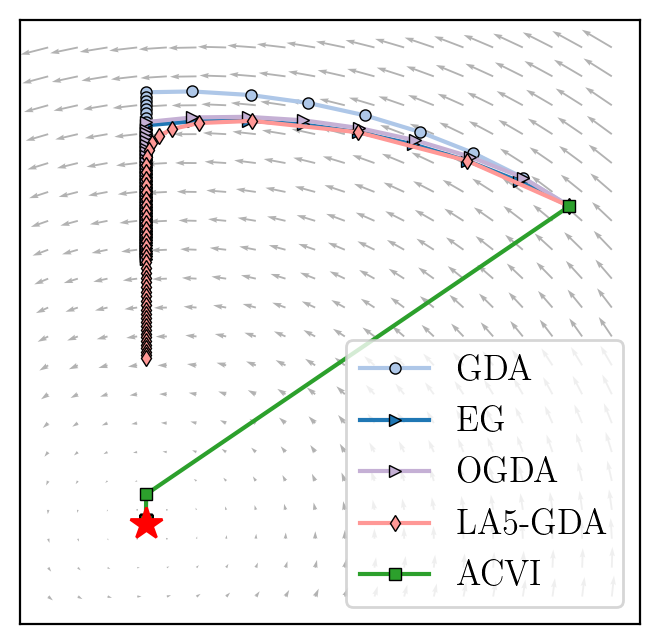

In [73]:
from IPython.core.pylabtools import figsize
from numpy.lib.function_base import meshgrid
import numpy as np
import scipy.optimize as opt
from scipy import linalg
import matplotlib.pyplot as plt
# F(x)= Ax; x >= 0;
A = np.array([[0.1,1],[-1,0.1]])
# Each algorithm is initialized at (1,1);

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

T, K, last_K = 20, 1, 30  # for acvi
n = (T-1)*K+last_K  # each algorithm runs n iterations
gamma = 0.1 

# GDA ---
z = np.ones((2,))
his_gda = [z]
for t in range(0, n):
  z = np.maximum(z-gamma*np.dot(A,z),0)
  his_gda.append(z)
his_gda = np.array(his_gda)
ax.plot(his_gda[:,0], his_gda[:,1], label='GDA', markersize=markersize, 
        color=c_gda, marker=m_gda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of GDA: {}'.format(z))

# EG ---
z = np.ones((2,))
his_eg = [z]
for t in range(0,n):
  zz = np.maximum(z-gamma*np.dot(A,z),0)
  z = np.maximum(z-gamma*np.dot(A,zz),0)
  his_eg.append(z)
his_eg = np.array(his_eg)
ax.plot(his_eg[:,0],his_eg[:,1],label='EG',markersize=markersize,
        color=c_eg, marker=m_eg, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of EG: {}'.format(z))

# OGDA ---
z1 = z0 = np.ones((2,))
his_ogda = [z0,z1]
for t in range(0,n):
  z = np.maximum(z1-2*gamma*np.dot(A,z1)+gamma*np.dot(A,z0),0)
  z0 = z1
  z1 = z
  his_ogda.append(z)
his_ogda = np.array(his_ogda)
ax.plot(his_ogda[:,0], his_ogda[:,1], label='OGDA', markersize=markersize,
        color=c_ogda, marker=m_eg, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of OGDA: {}'.format(z))

# LA5-GDA ---
k, alpha = 5, .5 
z = np.ones((2,))
his_lak = [z]
for t in range(0,n):
  z_old = z
  for i in range(1,k):
    z = np.maximum(z-gamma*np.dot(A,z),0)
  z = np.maximum(alpha*z_old+(1-alpha)*z,0)
  his_lak.append(z)
his_lak = np.array(his_lak)
ax.plot(his_lak[:,0], his_lak[:,1],'bo-', label='LA5-GDA', markersize=markersize,
        color=c_la, marker=m_la, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of LA{}-GDA: {}'.format(k,z))


# ACVI ---
beta, mu, delta = 0.08, 1e-5, 0.5
y, lmd = np.ones((2,)), np.zeros((2,))
def f_y(y,c,mu):
  return -mu*np.sum(np.log(y))+beta/2*np.sum((y-c)**2)

history_x,history_y,history_lmd=[],[y],[lmd]
for t in range(0,T):
  mu *= delta
  flag = 1
  if t >= T-1:
    K = last_K
  for k in range(0,K):
    x = linalg.solve(np.identity(2)+A/beta,y-lmd/beta)
    res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP')
    if(res.success == False):
      print('Failed to update y. t={}, k={}'.format(t,k))
      flag=0
      break
    y = res.x
    lmd += beta*(x-y)
    history_x.append(x)
    history_y.append(y)
    history_lmd.append(lmd)
  if flag == 0:
    break
history_x = np.array(history_x)
history_y = np.array(history_y)
history_lmd = np.array(history_lmd)
ax.plot(history_y[:,0], history_y[:,1], label='ACVI', markersize=markersize,
        color=c_acvi, marker=m_acvi, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of ACVI: {}'.format(y))

ax.plot([0],[0],'r*', markersize=markersize*3, markeredgewidth=1) 
print('Solution at: {}'.format([0,0]))
ax.legend(loc='lower right')

x1 = np.linspace(-0.23,1.1,20)
x2 = np.linspace(-0.23,1.5,20)
u1,u2 = meshgrid(x1,x2)
ax.quiver(u1,u2,-(A[0,0]*u1+A[0,1]*u2),-(A[1,0]*u1+A[1,1]*u2),
          alpha=alpha_field)

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.tick_params(axis='both', which='both', length=0)

plt.savefig('acvi_bilinear_2d.pdf', bbox_inches='tight')
plt.show()

# Von Neumann’s ratio game

In [63]:
# Ratio Game
# V(x,y)=(-1.2xy+0.9y-0.3)/(0.4y+0.1x+0.4)
import numpy as np
from sympy import symbols, diff
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import fsolve
from numpy.lib.function_base import meshgrid


u, v = symbols('u v', real=True)
print(diff((-1.2*u*v+0.9*v-0.3)/(0.4*v+0.1*u+0.4),u))
print(diff((-1.2*u*v+0.9*v-0.3)/(0.4*v+0.1*u+0.4),v))

-1.2*v/(0.1*u + 0.4*v + 0.4) - 0.625*(-1.2*u*v + 0.9*v - 0.3)/(0.25*u + v + 1)**2
(0.9 - 1.2*u)/(0.1*u + 0.4*v + 0.4) - 2.5*(-1.2*u*v + 0.9*v - 0.3)/(0.25*u + v + 1)**2


Last iteration of GDA: [1.         0.40899025]
Last iteration of EG: [1.         0.31963852]
Last iteration of OGDA: [0.96210846 0.00998014]
Last iteration of LA5-GDA: [0.93046437 0.0715176 ]
Last iteration of ACVI:  [0.95215009 0.05039387]
Solution at:  [0.951941, 0.050485]


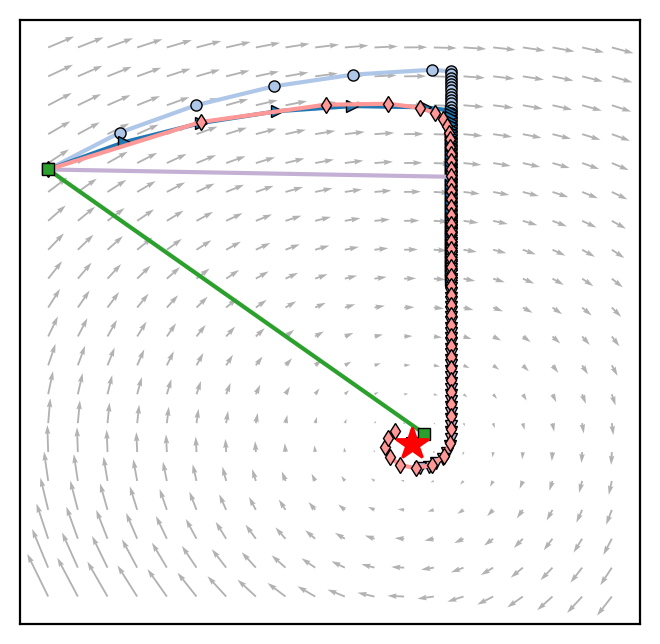

In [64]:
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.tick_params(axis='both', which='both', length=0)

init=1/2*np.ones((2,))  # initial point of every algorithm
def F(x):
  u=x[0]
  v=x[1]
  F1=-1.2*v/(0.1*u + 0.4*v + 0.4) - 0.625*(-1.2*u*v + 0.9*v - 0.3)/(0.25*u + v + 1)**2
  F2=(0.9 - 1.2*u)/(0.1*u + 0.4*v + 0.4) - 2.5*(-1.2*u*v + 0.9*v - 0.3)/(0.25*u + v + 1)**2
  return np.array([F1,-F2])


T,K=20,1  # for acvi
last_K=30  # for acvi
n=(T-1)*K+last_K # each algorithm runs n iterations


gamma=0.1

# GDA ---
z = init
his_gda = [z]
for t in range(0,n):
  z=np.clip(z-gamma*F(z),0,1)
  his_gda.append(z)
his_gda = np.array(his_gda)
ax.plot(his_gda[:,0], his_gda[:,1], label='GDA', markersize=markersize,
        color=c_gda, marker=m_gda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of GDA: {}'.format(z))

# EG ---
z = init
his_eg = [z]
for t in range(0,n):
  zz = np.clip(z-gamma*F(z),0,1)
  z = np.clip(z-gamma*F(zz),0,1)
  his_eg.append(z)
his_eg = np.array(his_eg)
ax.plot(his_eg[:,0], his_eg[:,1], label='EG', markersize=markersize,
        color=c_eg, marker=m_eg, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of EG: {}'.format(z))

# OGDA ---
Z1 = z0 = init
his_ogda = [z0,z1]
for t in range(0,n):
  z = np.clip(z1-2*gamma*F(z1)+gamma*F(z0),0,1)
  z0 = z1
  z1 = z
  his_ogda.append(z)
his_ogda = np.array(his_ogda)
ax.plot(his_ogda[:,0],his_ogda[:,1], label='OGDA',markersize=markersize,
        color=c_ogda, marker=m_ogda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of OGDA: {}'.format(z))

# LA5-GDA ---
k, alpha = 5, .5 
z = init
his_lak = [z]
for t in range(0,n):
  z_old = z
  for i in range(1,k):
    z = np.clip(z-gamma*F(z),0,1)
  z = np.clip(alpha*z_old+(1-alpha)*z,0,1)
  his_lak.append(z)
his_lak = np.array(his_lak)
ax.plot(his_lak[:,0],his_lak[:,1], label='LA5-GDA',markersize=markersize, 
        color=c_la, marker=m_la, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of LA5-GDA: {}'.format(z))


# ACVI ---
beta, mu, delta = 0.08, 1e-5, .5
x, y, lmd = init, init, np.zeros((2,))
def f_y(y,c,mu):
  return -mu*(np.sum(np.log(y))+np.sum(np.log(1-y)))+beta/2*np.sum((y-c)**2)  # 0<=y<=1
history_x, history_y, history_lmd = [x], [y], [lmd]
for t in range(0,T):
  mu *= delta
  flag = 1
  if t >= T-1:
    K = last_K
  for k in range(0,K):
    x = fsolve(lambda z: z+1/beta*F(z)-y+1/beta*lmd, x)
    res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP')
    if(res.success == False):
      print('Failed to update y. t={}, k={}'.format(t,k))
      flag = 0
      break
    y = res.x
    lmd += beta*(x-y)
    history_x.append(x)
    history_y.append(y)
    history_lmd.append(lmd)
  if flag == 0:
    break
history_x = np.array(history_x)
history_y = np.array(history_y)
history_lmd = np.array(history_lmd)
ax.plot(history_y[:,0], history_y[:,1], label='ACVI', markersize=markersize,
        color=c_acvi, marker=m_acvi, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of ACVI:  {}'.format(y))

ax.plot([0.951941],[0.050485],'r*', markersize=markersize*3, markeredgewidth=1) 
print('Solution at: ', [0.951941, 0.050485])

x1 = np.linspace(0.5,1.2,20)
x2 = np.linspace(-0.2,0.7,20)
u1, u2 = meshgrid(x1,x2)
ax.quiver(u1,u2,-F(np.array([u1,u2]))[0],-F(np.array([u1,u2]))[1],
           alpha=alpha_field)

plt.savefig('acvi_ratio_game_2d.pdf', bbox_inches='tight')
plt.show()

# Forsaken game

Last iteration of GDA: [ 0.15297475 -1.33053591]
Last iteration of EG: [ 0.53860144 -1.20651963]
Last iteration of OGDA: [ 0.52383978 -1.22440338]
Last iteration of LA5-GDA: [1.03260899 1.40345432]
Last iteration of ACVI: [0.07809761 0.41088699]
Solution at: [0.08, 0.4]


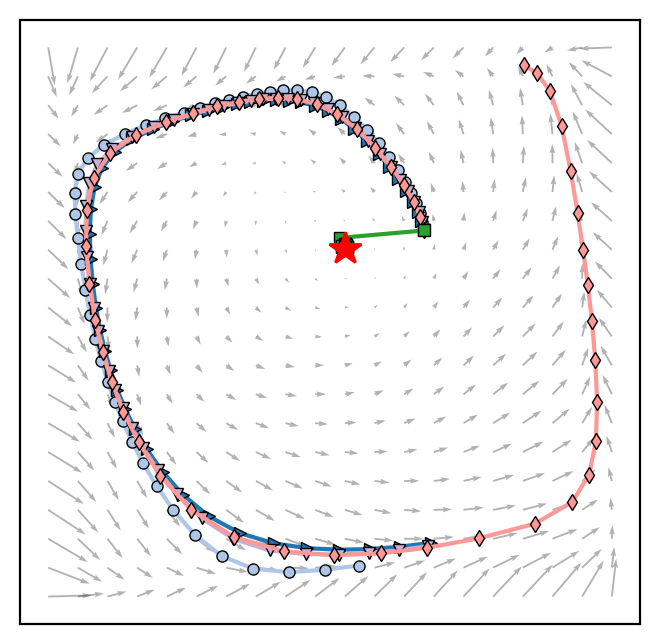

In [65]:
#@title Forsaken in the main part of the paper
# x*(y-0.45) + phi(x) - phi(y) s.t. x^T*x <= 4
# phi(x) = 1/4*x**2 - 1/2*x**4+1/6*z**6 
import numpy as np  
from sympy import symbols, diff
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import fsolve
from numpy.lib.function_base import meshgrid

def phi(x):
  return 1/4*x**2-1/2*x**4+1/6*x**6

u,v = symbols('u v', real=True)
# print(diff(u*(v-0.45)+phi(u)-phi(v),u))
# print(diff(u*(v-0.45)+phi(u)-phi(v),v))
fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.tick_params(axis='both', which='both', length=0)

init = 1/2*np.ones((2,))  # initial point of each algorithm

def F(x):
  u = x[0]
  v = x[1]
  F1 = 1.0*u**5 - 2.0*u**3 + 0.5*u + v - 0.45
  F2 = u - 1.0*v**5 + 2.0*v**3 - 0.5*v
  return np.array([F1,-F2])

T, K, last_K = 20, 1, 30  # for ACVI
n = (T-1)*K+last_K  # each algorithm runs n iterations


gamma = 0.1 

def proj(z):
  if np.linalg.norm(z)>2:
    z=2*z/np.linalg.norm(z)
  return z

# GDA ---
z = init
his_gda = [z]
for t in range(0,n):
  z = proj(z-gamma*F(z))
  his_gda.append(z)
his_gda=np.array(his_gda)
ax.plot(his_gda[:,0], his_gda[:,1], label='GDA', markersize=markersize, 
        color=c_gda, marker=m_gda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of GDA: {}'.format(z))

# EG ---
z = init
his_eg = [z]
for t in range(0,n):
  zz = proj(z-gamma*F(z))
  z = proj(z-gamma*F(zz))
  his_eg.append(z)
his_eg = np.array(his_eg)
ax.plot(his_eg[:,0], his_eg[:,1], label='EG', markersize=markersize, 
        color=c_eg, marker=m_eg, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of EG: {}'.format(z))

# OGDA ---
z1 = z0 = init
his_ogda = [z0,z1]
for t in range(0,n):
  z = proj(z1-2*gamma*F(z1)+gamma*F(z0))
  z0 = z1
  z1 = z
  his_ogda.append(z)
his_ogda = np.array(his_ogda)
ax.plot(his_ogda[:,0], his_ogda[:,1], label='OGDA', markersize=markersize, 
        color=c_ogda, marker=m_ogda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of OGDA: {}'.format(z))

# LA5-GDA ---
k, alpha = 4, .5 
z = init
his_lak = [z]
for t in range(0,n):
  z_old = z
  for i in range(1,k):
    z = proj(z-gamma*F(z))
  z = proj(alpha*z_old+(1-alpha)*z)
  his_lak.append(z)
his_lak = np.array(his_lak)
ax.plot(his_lak[:,0], his_lak[:,1], label='LA5-GDA', markersize=markersize, 
        color=c_la, marker=m_la, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of LA5-GDA: {}'.format(z))

# ACVI ---
beta, mu, delta = 0.08, 1e-5, 0.5
x, y, lmd = init, init, np.zeros((2,))
def f_y(y,c,mu):
  return -mu*(np.sum(np.log(4-np.dot(y,y))))+beta/2*np.sum((y-c)**2)  # 0<=y<=1

history_x, history_y, history_lmd = [x], [y], [lmd]
for t in range(0,T):
  mu = mu*delta
  flag = 1
  if t >= T-1:
    K = last_K
  for k in range(0,K):
    x = fsolve(lambda z: z+1/beta*F(z)-y+1/beta*lmd, x)
    res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP')
    if(res.success == False):
      print('Fail to update y. t={}, k={}'.format(t,k))
      flag = 0
      break
    y = res.x
    lmd += beta*(x-y)
    history_x.append(x)
    history_y.append(y)
    history_lmd.append(lmd)
  if flag == 0:
    break
history_x = np.array(history_x)
history_y = np.array(history_y)
history_lmd = np.array(history_lmd)
ax.plot(history_y[:,0], history_y[:,1], label='ACVI', markersize=markersize, 
        color=c_acvi, marker=m_acvi, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of ACVI: {}'.format(y))


ax.plot([0.08], [0.4], 'r*', label='Solution', markersize=markersize*3,
        markeredgewidth=1)
print('Solution at: {}'.format([0.08, 0.4]))

x1 = np.linspace(-1.5,1.5,20)
x2 = np.linspace(-1.5,1.5,20)
u1,u2 = meshgrid(x1,x2)
ax.quiver(u1,u2,-F(np.array([u1,u2]))[0],-F(np.array([u1,u2]))[1],
           alpha=alpha_field)

plt.savefig('forsaken.pdf', bbox_inches='tight')
plt.show()

1.0*u**5 - 2.0*u**3 + 0.5*u + v - 0.45
u - 1.0*v**5 + 2.0*v**3 - 0.5*v
Last iteration of ACVI: [0.08       0.41611534]
Last iteration of GDA: [0.08       1.32237051]
Last iteration of EG: [0.08       1.32236801]
Last iteration of OGDA: [0.08       1.32237032]
Last iteration of LA4-GDA: 
Solution at: [0.08, 0.4]


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: invalid value encountered in log


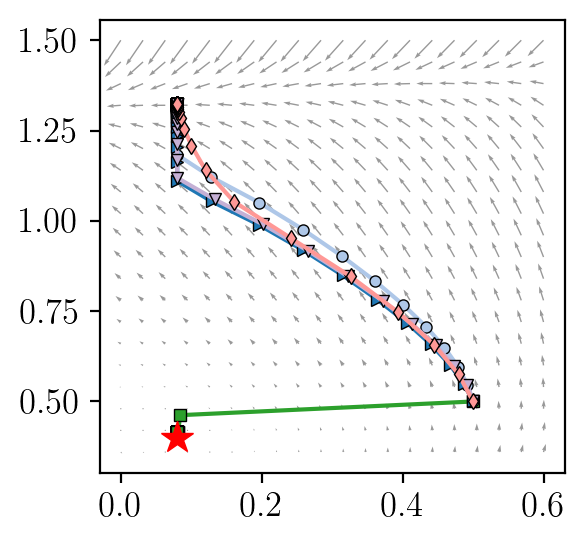

In [66]:
#@title Appendix Forsaken: Changed constraint to: x_1 >= 0.08
# x*(y-0.45)+phi(x)-phi(y) x^T*x<=4
# phi(x)=1/4*x**2-1/2*x**4+1/6*z**6 
import numpy as np  
from sympy import symbols, diff
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import fsolve
from numpy.lib.function_base import meshgrid

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=200)

def phi(x):
  return 1/4*x**2-1/2*x**4+1/6*x**6
u, v = symbols('u v', real=True)
print(diff(u*(v-0.45)+phi(u)-phi(v),u))
print(diff(u*(v-0.45)+phi(u)-phi(v),v))
init = 1/2 * np.ones((2,)) # initial point of each algorithm

def F(x):
  u, v =x[0], x[1]
  F1 = 1.0*u**5 - 2.0*u**3 + 0.5*u + v - 0.45
  F2 = u - 1.0*v**5 + 2.0*v**3 - 0.5*v
  return np.array([F1, -F2])

# ACVI ---
beta, mu, delta = 0.08, 1e-5, 0.5
T, K, last_K = 20, 1, 30
n = (T-1)*K + last_K  # each algorithm runs n iterations
x, y, lmd = init, init, np.zeros((2,))
def f_y(y,c,mu):
  return -mu*(np.sum(np.log(y[0]-0.08))) + beta/2*np.sum((y-c)**2)

history_x, history_y, history_lmd = [x], [y], [lmd]
for t in range(0,T):
  mu *= delta
  flag = 1
  K = last_K if t >= T-1 else K
  for k in range(0,K):
    x = fsolve(lambda z: z+1/beta*F(z)-y+1/beta*lmd, x)
    res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP')
    if(res.success == False):
      print('Fail to update y. t={}, k={}'.format(t,k))
      flag=0
      break
    y = res.x
    lmd += beta*(x-y)
    history_x.append(x)
    history_y.append(y)
    history_lmd.append(lmd)
  if flag == 0:
    break
history_x = np.array(history_x)
history_y = np.array(history_y)
history_lmd = np.array(history_lmd)
ax.plot(history_y[:,0], history_y[:,1], label='ACVI', markersize=markersize,
         color=c_acvi, marker=m_acvi, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of ACVI: {}'.format(y))

gamma=0.1

# GDA ---
def proj(z):
  if z[0] < .08:
    z[0] = .08
  return z

z = init
his_gda = [z]
for t in range(0,n):
  z = proj(z-gamma*F(z))
  his_gda.append(z)
his_gda = np.array(his_gda)
ax.plot(his_gda[:,0], his_gda[:,1], label='GDA', markersize=markersize, 
        color=c_gda, marker=m_gda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of GDA: {}'.format(z))

# EG ---
z = init
his_eg = [z]
for t in range(0,n):
  z = proj(z-gamma*F( proj(z-gamma*F(z)) ))
  his_eg.append(z)
his_eg = np.array(his_eg)
ax.plot(his_eg[:,0], his_eg[:,1], label='EG', markersize=markersize,
         color=c_eg, marker=m_eg, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of EG: {}'.format(z))

# OGDA ---
z0 = init
z1 = z0
his_ogda=[z0,z1]
for t in range(0,n):
  z = proj(z1-2*gamma*F(z1)+gamma*F(z0))
  z0 = z1
  z1 = z
  his_ogda.append(z)
his_ogda = np.array(his_ogda)
ax.plot(his_ogda[:,0], his_ogda[:,1], label='OGDA', markersize=markersize,
         color=c_ogda, marker=m_ogda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of OGDA: {}'.format(z)) 

# LAK-GDA ---
k, alpha = 4, .5
z = init
his_lak = [z]
for t in range(0,n):
  z_old = z
  for i in range(1,k):
    z = proj(z-gamma*F(z))
  z = proj(alpha*z_old+(1-alpha)*z)
  his_lak.append(z)
his_lak = np.array(his_lak)
ax.plot(his_lak[:,0], his_lak[:,1], label='LA4-GDA', markersize=markersize,
         color=c_la, marker=m_la, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of LA{}-GDA: '.format(k, z))

plt.plot([0.08],[0.4], 'r*', markersize=12, markeredgewidth=.5) 
print('Solution at: {}'.format([.08, .4]))

x1 = np.linspace(0,0.6,20)
x2 = np.linspace(0.36,1.5,20)
u1, u2 = meshgrid(x1,x2)
plt.quiver(u1,u2,-F(np.array([u1,u2]))[0], -F(np.array([u1,u2]))[1], alpha=0.4)

plt.savefig('forsaken_constr2_cx.pdf', bbox_inches = 'tight')
plt.show()

1.0*u**5 - 2.0*u**3 + 0.5*u + v - 0.45
u - 1.0*v**5 + 2.0*v**3 - 0.5*v
Last iteration of ACVI: [0.0788703 0.4116322]
Last iteration of GDA: [-1.29586966  0.4       ]
Last iteration of EG: [-1.29579574  0.4       ]
Last iteration of OGDA: [-1.29585386  0.4       ]
Last iteration of LA4-GDA: [-1.29586881  0.4       ]
Solution at: [0.08, 0.4]


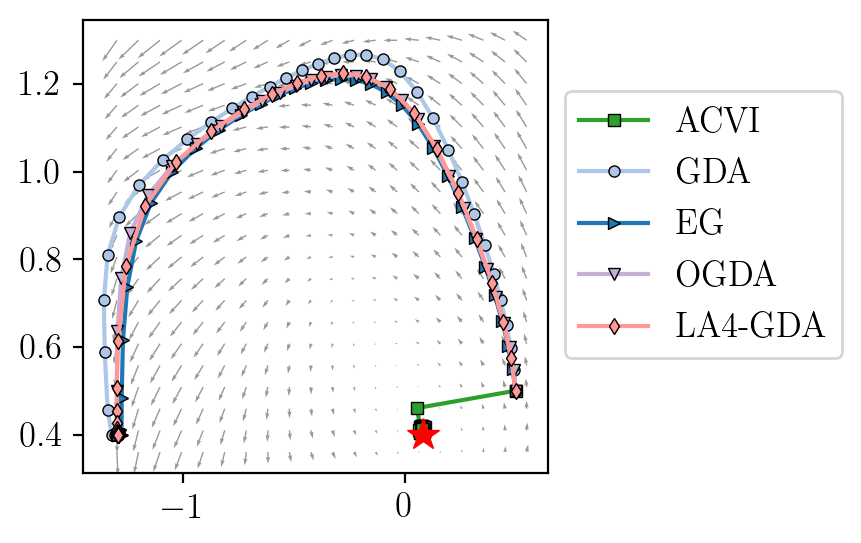

In [67]:
#@title Appendix Forsaken: Changed constraint to: x_2 >= 0.4
# x*(y-0.45)+phi(x)-phi(y) x^T*x<=4
# phi(x)=1/4*x**2-1/2*x**4+1/6*z**6 
import numpy as np  
from sympy import symbols, diff
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import fsolve
from numpy.lib.function_base import meshgrid

fig, ax = plt.subplots(1,1, figsize=(3,3), dpi=200)

def phi(x):
  return 1/4*x**2-1/2*x**4+1/6*x**6

u, v = symbols('u v', real=True)
print(diff(u*(v-0.45)+phi(u)-phi(v),u))
print(diff(u*(v-0.45)+phi(u)-phi(v),v))

init = 1/2*np.ones((2,))  # initial point of each algorithm
def F(x):
  u, v = x[0], x[1]
  F1 = 1.0*u**5 - 2.0*u**3 + 0.5*u + v - 0.45
  F2 = u - 1.0*v**5 + 2.0*v**3 - 0.5*v
  return np.array([F1, -F2])

# ACVI ---
beta, mu, delta = 0.08, 1e-5, 0.5
T, K, last_K = 20, 1, 30
n = (T-1)*K + last_K  # each algo runs n iterations
x, y, lmd = init, init, np.zeros((2,))

def f_y(y,c,mu):
  return -mu*(np.sum(np.log(y[1]-0.4)))+beta/2*np.sum((y-c)**2)

history_x, history_y, history_lmd= [x], [y], [lmd]
for t in range(0,T):
  mu = mu*delta
  flag = 1
  if t >= T-1:
    K = last_K
  for k in range(0,K):
    x = fsolve(lambda z: z+1/beta*F(z)-y+1/beta*lmd, x)
    res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, 
                       method='SLSQP')
    if(res.success==False):
      print('Fail to update y. t={}, k={}'.format(t,k))
      flag=0
      break
    y = res.x
    lmd += beta*(x-y)
    history_x.append(x)
    history_y.append(y)
    history_lmd.append(lmd)
  if flag == 0:
    break
history_x = np.array(history_x)
history_y = np.array(history_y)
history_lmd = np.array(history_lmd)
ax.plot(history_y[:,0], history_y[:,1], label='ACVI', markersize=markersize,
         color=c_acvi, marker=m_acvi, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of ACVI: {}'.format(y))

gamma=0.1 

def proj(z):
  if z[1]<0.4:
    z[1]=0.4
  return z

# GDA ---
z = init
his_gda = [z]
for t in range(0,n):
  z = proj(z-gamma*F(z))
  his_gda.append(z)
his_gda=np.array(his_gda)
ax.plot(his_gda[:,0], his_gda[:,1], label='GDA', markersize=markersize, 
        color=c_gda, marker=m_gda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of GDA: {}'.format(z))

# EG ---
z = init
his_eg = [z]
for t in range(0,n):
  z = proj(z-gamma*F( proj(z-gamma*F(z)) ))
  his_eg.append(z)
his_eg=np.array(his_eg)
ax.plot(his_eg[:,0], his_eg[:,1], label='EG', markersize=markersize,
         color=c_eg, marker=m_eg, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of EG: {}'.format(z))

# OGDA ---
z1 = z0 = init
his_ogda=[z0,z1]
for t in range(0,n):
  z = proj(z1- 2*gamma*F(z1) + gamma*F(z0))
  z0 = z1
  z1 = z
  his_ogda.append(z)
his_ogda = np.array(his_ogda)
ax.plot(his_ogda[:,0], his_ogda[:,1], label='OGDA', markersize=markersize,
         color=c_ogda, marker=m_ogda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of OGDA: {}'.format(z))

# LAK-GDA ---
k, alpha = 4, .5 
z = init
his_lak = [z]
for t in range(0,n):
  z_old = z
  for i in range(1,k):
    z = proj(z-gamma*F(z))
  z = proj(alpha*z_old+(1-alpha)*z)
  his_lak.append(z)
his_lak = np.array(his_lak)
ax.plot(his_lak[:,0],his_lak[:,1],'bo-',label='LA4-GDA',markersize=markersize,
         color=c_la, marker=m_la, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of LA{}-GDA: {}'.format(k,z))

plt.plot([0.08],[0.4],'r*',markersize=12,markeredgewidth=0.5) 
print('Solution at: {}'.format([.08, .4]))
ax.legend(bbox_to_anchor=(1, 0.88))

x1 = np.linspace(-1.3,0.55,20)
x2 = np.linspace(0.36,1.3,20)
u1, u2 = meshgrid(x1,x2)
plt.quiver(u1,u2,-F(np.array([u1,u2]))[0], -F(np.array([u1,u2]))[1], alpha=.4)

plt.savefig('forsaken_constraint3_cy.pdf',bbox_inches = 'tight')
plt.show()

# Toy GAN

Last iteration of GDA: [-0.00031065 -0.1619776 ]
Last iteration of EG: [ 1.00657749 -0.00109703]
Last iteration of OGDA: [-1.26427168 -1.54971517]
Last iteration of LA5-GDA: [ 1.00719273e+00 -5.20005032e-04]
Last iteration of ACVI: [1.0137749  0.00702217]
Solution at: [1.00648241e+00 1.50753769e-04]


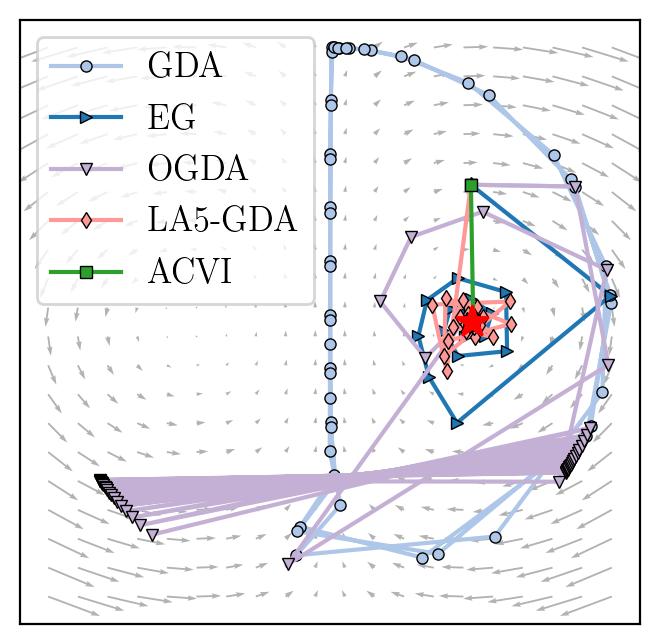

In [71]:
# min(theta)max(phi)E(x~N(0,Sigma))[x^T phi x]-E(z~N(0,1))[(theta z)^T phi (theta z)]
# theta^2 + phi^2 <= 4
import numpy as np
from sympy import symbols, diff
import matplotlib.pyplot as plt
import scipy.optimize as opt
from scipy.optimize import fsolve
from numpy.lib.function_base import meshgrid

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
ax.tick_params(axis='both', which='both', length=0)

mean, cov = 0, 2
N = 1000  # number of samples
np.random.seed(0)
d1 = np.random.normal(mean,cov,N)
np.random.seed(1)
d2 = np.random.normal(mean,cov,N)

def F(x):
  theta = x[0]
  phi = x[1]
  F1 = -2 * theta * phi * np.mean(d2**2)
  F2 = np.mean(d1**2) - (theta**2)*np.mean(d2**2)
  return np.array([F1,-F2])

init = np.ones((2,))  # initial point of each algorithm

T, K, last_K =20,1, 30  # for acvi
n = (T-1)*K + last_K  # each algorithm runs n iterations


gamma = 0.1 
def proj(z):
  return 2*z/np.linalg.norm(z) if np.linalg.norm(z)>2 else z

# GDA ---
z = init
his_gda = [z]
for t in range(0,n):
  z = proj(z-gamma*F(z))
  his_gda.append(z)
his_gda = np.array(his_gda)
ax.plot(his_gda[:,0], his_gda[:,1], label='GDA', markersize=markersize, 
        color=c_gda, marker=m_gda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of GDA: {}'.format(z))

# EG ---
z = init
his_eg = [z]
for t in range(0,n):
  z = proj(z-gamma*F( proj(z-gamma*F(z)) ))
  his_eg.append(z)
his_eg = np.array(his_eg)
ax.plot(his_eg[:,0], his_eg[:,1], label='EG', markersize=markersize, 
        color=c_eg, marker=m_eg, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of EG: {}'.format(z))

# OGDA ---
z1 = z0 = init
his_ogda = [z0,z1]
for t in range(0,n):
  z = proj(z1-2*gamma*F(z1)+gamma*F(z0))
  z0 = z1
  z1 = z
  his_ogda.append(z)
his_ogda = np.array(his_ogda)
ax.plot(his_ogda[:,0], his_ogda[:,1], label='OGDA', markersize=markersize, 
        color=c_ogda, marker=m_ogda, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of OGDA: {}'.format(z))


# LA5-GDA ---
k, alpha = 5, .5
z = init
his_lak = [z]
for t in range(0,n):
  z_old = z
  for i in range(1,k):
    z = proj(z-gamma*F(z))
  z = proj(alpha*z_old + (1-alpha)*z)
  his_lak.append(z)
his_lak=np.array(his_lak)
ax.plot(his_lak[:,0],his_lak[:,1],'bo-',label='LA5-GDA',markersize=markersize, 
        color=c_la, marker=m_la, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of LA{}-GDA: {}'.format(k,z))

# ACVI ---
beta,mu,delta=0.08,1e-5,0.5
x,y,lmd=init,init,np.zeros((2,))
def f_y(y,c,mu):
  return -mu*(np.sum(np.log(4-np.dot(y,y))))+beta/2*np.sum((y-c)**2) #0<=y<=1

history_x,history_y,history_lmd=[x],[y],[lmd]
for t in range(0,T):
  mu *= delta
  flag = 1
  if t >= T-1:
    K = last_K
  for k in range(0,K):
    x = fsolve(lambda z: z+1/beta*F(z)-y+1/beta*lmd, x)
    res = opt.minimize(lambda z: f_y(z,x+lmd/beta,mu), y, method='SLSQP')
    if(res.success==False):
      print('Fail to update y. t={}, k={}'.format(t,k))
      flag=0
      break
    y = res.x
    lmd += beta*(x-y)
    history_x.append(x)
    history_y.append(y)
    history_lmd.append(lmd)
  if flag == 0:
    break
history_x = np.array(history_x)
history_y = np.array(history_y)
history_lmd = np.array(history_lmd)
ax.plot(history_y[:,0],history_y[:,1],'gv-',label='ACVI',markersize=markersize, 
        color=c_acvi, marker=m_acvi, markeredgewidth=m_edge_width, markeredgecolor='k')
print('Last iteration of ACVI: {}'.format(y))

# find a solution ---
x1 = np.linspace(0.97,1.03,200)
x2 = np.linspace(-0.03,0.03,200)
u1, u2 = meshgrid(x1, x2)
F1, F2 = F(np.array([u1,u2]))[0], F(np.array([u1,u2]))[1]
opt = np.argmin(F1**2+F2**2)
r, c = opt//F1.shape[0], opt%F1.shape[1]
# print((F1**2+F2**2)[r,c]) # 1.6387702899057624e-06
ax.plot([u1[r,c]],[u2[r,c]],'r*',markersize=markersize*3,markeredgewidth=1)
print('Solution at: {}'.format(np.array([u1[r,c],u2[r,c]])))
ax.legend(loc='upper left')

x1 = np.linspace(-2,2,20)
x2 = np.linspace(-2,2,20)
u1, u2 = meshgrid(x1,x2)
ax.quiver(u1,u2,-F(np.array([u1,u2]))[0],-F(np.array([u1,u2]))[1],
           alpha=alpha_field)


plt.savefig('acvi_gan_2d.pdf', bbox_inches='tight')
plt.show()